In [1]:
!pip install imutils



  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25847 sha256=9d36fc6b8dad76ec96b7211478a271991f530690a478db71f837ccf3025c4fb4
  Stored in directory: c:\users\comp\appdata\local\pip\cache\wheels\c2\02\32\f3617a9f68bcc67eda3ebeb4514eba18f62e81ff439428109d
Successfully built imutils


In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization


In [3]:
dir = "C:/Users/comp/OneDrive/Desktop/college/Research papers/OCR/archive/dataset/Train"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [4]:
val_dir = "C:/Users/comp/OneDrive/Desktop/college/Research papers/OCR/archive/dataset/Validation"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [5]:
random.shuffle(train_data)
random.shuffle(val_data)
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [6]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [8]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [9]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
4375/4375 [==============================] - 191s 43ms/step - loss: 0.5394 - accuracy: 0.8249 - val_loss: 0.7221 - val_accuracy: 0.8382
Epoch 2/50
4375/4375 [==============================] - 172s 39ms/step - loss: 0.2980 - accuracy: 0.8946 - val_loss: 0.6576 - val_accuracy: 0.8524
Epoch 3/50
4375/4375 [==============================] - 161s 37ms/step - loss: 0.2582 - accuracy: 0.9065 - val_loss: 0.5797 - val_accuracy: 0.8836
Epoch 4/50
4375/4375 [==============================] - 166s 38ms/step - loss: 0.2395 - accuracy: 0.9126 - val_loss: 0.6527 - val_accuracy: 0.8717
Epoch 5/50
4375/4375 [==============================] - 168s 38ms/step - loss: 0.2247 - accuracy: 0.9165 - val_loss: 0.6211 - val_accuracy: 0.8698
Epoch 6/50
4375/4375 [==============================] - 157s 36ms/step - loss: 0.2127 - accuracy: 0.9208 - val_loss: 0.6509 - val_accuracy: 0.8816
Epoch 7/50
4375/4375 [==============================] - 158s 36ms/step - loss: 0.2062 - accuracy: 0.9230 - val_loss: 0

In [10]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    
    return (cnts, boundingBoxes)

In [11]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image


In [12]:
def get_word(letter):
    word = "".join(letter)
    return word

1/1 [==============================] - 0s 22ms/step
PARENT


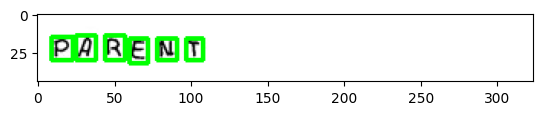

In [15]:
letter,image = get_letters("C:/Users/comp/OneDrive/Desktop/college/Research papers/OCR/archive (1)/test_v2/test/TEST_0069.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)